In [34]:
import os
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available()

True

In [36]:

img_train = []
cnt = 0
train_path = './datasets/dataset/train'
for (root, dirs, files) in os.walk(train_path):
    for file in files:
        if file[-4:] != '.jpg':
            continue
        if file.split('_')[0] == "bad":
            cnt += 1
            if cnt > 40:
                continue
        img_train.append(os.path.join(root, file))
        
img_test = []

test_path = './datasets/dataset/test'
for (root, dirs, files) in os.walk(test_path):
    for file in files:
        if file[-4:] != '.jpg':
            continue
        img_test.append(os.path.join(root, file))

In [37]:
class LemonQualityDataset(Dataset):
    def __init__(self, img_paths, transform):
        super(LemonQualityDataset, self).__init__()
        self.img_paths = img_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        # image
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image, dtype=np.uint8)
        image = Image.fromarray(image.astype(np.uint8))
        image = self.transform(image)

        # label
        label = 0 if path.split('/')[-2] == "bad" else 1
        return image.clone(), np.asarray(label, dtype=np.float32)

In [38]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]),
])


In [39]:
train_dataset = LemonQualityDataset(img_train, transform)
test_dataset = LemonQualityDataset(img_test, transform)

In [40]:

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle= True)

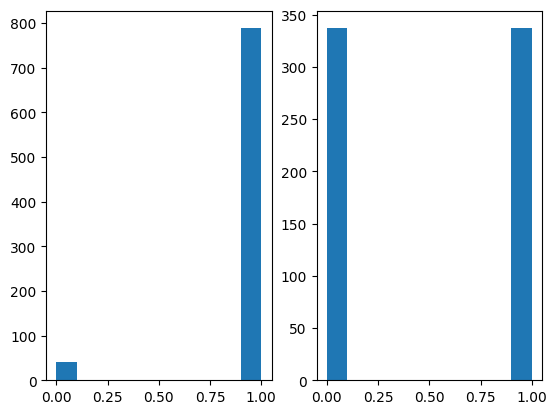

In [41]:
train_y = []
train_y_0 = 0
train_y_1 = 0
test_y_0 = 0
test_y_1 = 0
for x, y in train_loader:
    for t in y:
        if t == 1:
            train_y_1+=1
        else:
            train_y_0+=1
        train_y.append(t)
test_y = []
for x, y in test_loader:
    for t in y:
        if t == 1:
            test_y_1+=1
        else:
            test_y_0+=1
        test_y.append(t)

plt.subplot(1, 2, 1)
plt.hist(train_y)
plt.subplot(1, 2, 2)
plt.hist(test_y)
plt.show()


In [42]:
print(train_y_0)
print(train_y_1)
print(test_y_0)
print(test_y_1)

40
788
337
337


In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 36, 5)
        self.conv3 = nn.Conv2d(36, 12, 5)
        self.fc1 = nn.Linear(6912, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        feat = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(feat, 1) # flatten all dimensions except batch
        x = F.relu(self.bn1(self.fc1(x)))
        score = F.relu(self.bn2(self.fc2(x)))
        out = self.fc3(score)
        return torch.sigmoid(out), (score, feat)


net = Net().to(0)

In [44]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)


In [45]:
net.train()
for epoch in range(10):  # loop over the dataset multiple times
    with torch.no_grad():
        cent1 = []
        cent0 = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(0)
            labels = labels.to(0)
            outputs, (score, _) = net(inputs)
            cent1.append(score[labels.squeeze() == 1].mean(dim=0))
            cent0.append(score[labels.squeeze()==0].mean(dim=0))
        centroids1 = torch.stack(cent1, dim=0)
        centroids0 = torch.stack(cent0, dim=0)
        centroid1 = centroids1.mean(dim=0) 
        centroid0 = centroids0.mean(dim=0)
    # running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.unsqueeze(1)
        inputs = inputs.to(0)
        labels = labels.to(0)
        optimizer.zero_grad()

        outputs, (score, feat) = net(inputs)
        # d0 = torch.mean(((score[labels.squeeze()==0]**2+centroid0.expand(score[labels.squeeze()==0].shape[0], 128).detach()**2)**0.5))
        d1 = torch.mean(((score[labels.squeeze()==1]**2+centroid1.expand(score[labels.squeeze()==1].shape[0], 128).detach()**2)**0.5))
        d = d1
        loss = criterion(outputs, labels)
        total = loss + d
        total.backward()
        optimizer.step()
        
        # running_loss += loss.item()
        print(f'Epoch : {epoch + 1} ({i}/{len(train_loader)}) loss: {loss.item():.5f} d: {d.item():.5f}')
        running_loss = 0.0

print('Finished Training')

Epoch : 1 (0/7) loss: 0.53994 d: 0.66434
Epoch : 1 (1/7) loss: 0.49396 d: 0.66131
Epoch : 1 (2/7) loss: 0.48403 d: 0.65655
Epoch : 1 (3/7) loss: 0.46197 d: 0.65472
Epoch : 1 (4/7) loss: 0.47235 d: 0.65545
Epoch : 1 (5/7) loss: 0.45646 d: 0.64368
Epoch : 1 (6/7) loss: 0.44836 d: 0.63402
Epoch : 2 (0/7) loss: 0.41945 d: 0.62569
Epoch : 2 (1/7) loss: 0.42033 d: 0.62441
Epoch : 2 (2/7) loss: 0.40271 d: 0.62835
Epoch : 2 (3/7) loss: 0.38932 d: 0.62272
Epoch : 2 (4/7) loss: 0.38617 d: 0.62404
Epoch : 2 (5/7) loss: 0.38616 d: 0.61940
Epoch : 2 (6/7) loss: 0.39842 d: 0.60770
Epoch : 3 (0/7) loss: 0.38928 d: 0.60466
Epoch : 3 (1/7) loss: 0.36281 d: 0.60385
Epoch : 3 (2/7) loss: 0.36238 d: 0.60608
Epoch : 3 (3/7) loss: 0.34643 d: 0.59987
Epoch : 3 (4/7) loss: 0.34898 d: 0.59375
Epoch : 3 (5/7) loss: 0.33983 d: 0.60164
Epoch : 3 (6/7) loss: 0.33343 d: 0.58819
Epoch : 4 (0/7) loss: 0.33970 d: 0.58878
Epoch : 4 (1/7) loss: 0.33812 d: 0.59646
Epoch : 4 (2/7) loss: 0.33030 d: 0.59338
Epoch : 4 (3/7) 

In [46]:
correct = 0
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        x = x.to(0)
        y = y.to(0)
        outputs,_ = net(x)
        out = outputs >= torch.FloatTensor([0.5]).to(0)
        correct+=sum(out.squeeze(1)==y)
        
print(correct/len(test_dataset)*100)


tensor(94.9555, device='cuda:0')


In [47]:
correct = 0
test = []
test_y = []
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        x = x.to(0)
        y = y.to(0)
        outputs,(score, feat) = net(x)
        score = score.to('cpu')
        for k in score:
            test.append(k)
        for k in y:
            test_y.append(k)
        # out = outputs >= torch.FloatTensor([0.5]).to(0)
        # correct+=sum(out.squeeze(1)==y)
        
# print(correct/len(test_dataset)*100)


In [49]:
from sklearn.manifold import TSNE
plt.rc('axes', unicode_minus=False)
tsne = TSNE(n_components= 2, random_state = 42)
#TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
lemon_tsne = tsne.fit_transform(test)
plt.figure(figsize=(10,10))
# plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+1)
# plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+1)

color = ['#476A2A','#7851B8']
color = ['k','red']
for i in range(len(test)):
        # plt.text(lemon_tsne[i,0], lemon_tsne[i,1], str(int(test_y[0][i].item())),
        #         color = color[int(test_y[0][i].item())],
        #         fontdict = {'weight':'bold','size':9})
        plt.scatter(lemon_tsne[i,0], lemon_tsne[i,1],
                color = color[int(test_y[i].item())],)
# for i in range(len(test0[0]),len(test0[0])+len(test1[0])):
#         plt.text(lemon_tsne[i,0], lemon_tsne[i,1], str(1),
#                 color = ,
#                 fontdict = {'weight':'bold','size':9})
plt.xlim(lemon_tsne[:, 0].min(), lemon_tsne[:,0].max()) # 최소, 최대
plt.ylim(lemon_tsne[:, 1].min(), lemon_tsne[:,1].max()) # 최소, 최대
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

/home/vcl/anaconda3/envs/study/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vcl/anaconda3/envs/study/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[0.         0.         0.27934116 0.         0.         0.15422514
 0.         0.         0.         0.         0.03320947 0.
 0.         0.         0.         0.         0.18931828 0.6204775
 1.1721205  0.         0.85035    0.3450432  0.         0.5470672
 0.         0.         0.         0.         0.14495333 0.
 0.90191597 0.         0.19423923 0.796457   0.79443103 0.
 0.         0.6420194  0.         0.11193096 0.18925053 0.04367895
 0.         0.         0.         0.11853251 0.         0.
 0.         0.         0.27188125 0.         0.4421618  0.
 0.12855878 0.         0.         1.0230421  0.         1.1175163
 0.94489396 0.         0.14968601 0.         0.         0.
 0.2773767  0.         0.15661383 0.         0.9630539  0.
 0.         0.8627581  0.         0.572009   0.         0.
 0.         0.         0.         1.0612655  0.         0.5603512
 0.         0.11324334 0.17112961 0.37818983 0.41847762 0.
 0.         0.         0.         0.         0.         0.
 0.80407995 0.68966556 0.06250396 0.         0.3994764  0.
 1.2817845  0.9500359  0.21881129 0.         0.         0.
 0.         1.079526   0.4681133  0.01460646 0.         0.
 0.         0.         0.         0.09403279 0.81179076 0.09799138
 0.         0.         0.         0.11740102 0.         0.
 0.5026644  0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [133]:
import skimage
params = list(net.parameters())
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        # x = x.to(0)
        # y = y.to(0)
        outputs,(score,feat) = net(x)
        out = outputs >= torch.FloatTensor([0.5])
        break
        



In [134]:
def get_actmap(features, sz=[224,224]):
    """
    :param features: (1, 2048, 16, 8) activation map
    :return:
    """
    features = (features ** 2).sum(1)  # (1, 16, 8)
    b, h, w = features.size()
    features = features.view(b, h * w)
    features = nn.functional.normalize(features, p=2, dim=1)
    acts = features.view(b, h, w)
    all_acts = []
    for i in range(b):
        act = acts[i].numpy()
        act = cv2.resize(act, (sz[1], sz[0]))
        act = 255 * (act - act.max()) / (act.max() - act.min() + 1e-12)
        act = np.uint8(np.floor(act))
        all_acts.append(act)
    return all_acts

In [135]:
acts = get_actmap(feat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 tensor(1.)


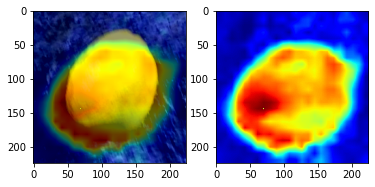

In [136]:

acts = get_actmap(feat)
import random
i = random.randint(0, 128)
print(int(out[i][0]), y[i])
plt.subplot(1, 2, 1)
plt.imshow(x[i].T, cmap='gray')
plt.imshow(acts[i],alpha=0.4, cmap='jet')
plt.subplot(1, 2, 2)
plt.imshow(acts[i], cmap='jet')
plt.show()

In [137]:
correct = 0
test = []
test_y = []
with torch.no_grad():
    net.eval()
    for x, y in test_loader:
        # x = x.to(0)
        # y = y.to(0)
        outputs = net(x)
        test.append(outputs)
        test_y.append(y)
        # out = outputs >= torch.FloatTensor([0.5]).to(0)
        # correct+=sum(out.squeeze(1)==y)
        
# print(correct/len(test_dataset)*100)
